# Analysis: Layer 35 Steering Sweep ("Tell me about the sun")

Post-hoc analysis of the 06.2 layer 35 steering experiment.

**Data source:** `../data/results/steering_deep_space_layer34.csv` (actually layer 35, filename is misleading)

**Experiment recap:**
- Layer 35 steering
- α ∈ [-10, 10] with 1000 samples
- Prompt: "Tell me about the sun? Please do not use Markdown."
- Result: 100% coherent across full range!

**Analysis goals:**
1. Find the "most linear" subrange within the full α span
2. Compare full-range vs optimal-range linear fits
3. Understand where and why linearity breaks down

## Setup

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
from tqdm.auto import tqdm

# Load results
df = pd.read_csv('../data/results/steering_deep_space_layer35.csv')

print(f"✓ Loaded {len(df)} samples")
print(f"  α range: [{df['alpha'].min():.2f}, {df['alpha'].max():.2f}]")
print(f"  Grade level range: [{df['grade_level'].min():.1f}, {df['grade_level'].max():.1f}]")
print(f"  Coherent: {df['coherent'].sum()} / {len(df)} ({df['coherent'].mean()*100:.1f}%)")

✓ Loaded 1000 samples
  α range: [-10.00, 10.00]
  Grade level range: [5.6, 38.0]
  Coherent: 1000 / 1000 (100.0%)


## Full Range Linear Regression (Baseline)

In [3]:
# Fit linear model to full range
slope_full, intercept_full, r_value_full, p_value_full, std_err_full = linregress(
    df['alpha'], df['grade_level']
)
r_squared_full = r_value_full ** 2

print("Full range linear fit:")
print(f"  y = {intercept_full:.2f} + {slope_full:.3f}α")
print(f"  R² = {r_squared_full:.4f}")
print(f"  p-value = {p_value_full:.2e}")
print(f"  Std error = {std_err_full:.3f}")

Full range linear fit:
  y = 11.22 + 0.581α
  R² = 0.6898
  p-value = 6.21e-256
  Std error = 0.012


## Exhaustive Search for Most Linear Subrange

We'll try all possible contiguous subranges [α_min, α_max] and find which has the highest R².

In [4]:
# Get unique alpha values (sorted)
alphas = df['alpha'].sort_values().unique()
n_alphas = len(alphas)

print(f"Testing all subranges...")
print(f"  Total α values: {n_alphas}")
print(f"  Number of possible ranges: {n_alphas * (n_alphas - 1) // 2}")

# Store results
results = []

# Minimum range width (in number of samples)
MIN_WIDTH = 50  # At least 50 samples for meaningful regression

# Try all ranges
for i in tqdm(range(n_alphas - MIN_WIDTH)):
    for j in range(i + MIN_WIDTH, n_alphas):
        alpha_min = alphas[i]
        alpha_max = alphas[j]
        
        # Get subset
        mask = (df['alpha'] >= alpha_min) & (df['alpha'] <= alpha_max)
        subset = df[mask]
        
        # Fit linear model
        slope, intercept, r_value, p_value, std_err = linregress(
            subset['alpha'], subset['grade_level']
        )
        r_squared = r_value ** 2
        
        results.append({
            'alpha_min': alpha_min,
            'alpha_max': alpha_max,
            'range_width': alpha_max - alpha_min,
            'n_samples': len(subset),
            'slope': slope,
            'intercept': intercept,
            'r_squared': r_squared,
            'p_value': p_value,
        })

results_df = pd.DataFrame(results)

print(f"\n✓ Tested {len(results_df)} subranges")

Testing all subranges...
  Total α values: 1000
  Number of possible ranges: 499500


  0%|          | 0/950 [00:00<?, ?it/s]


✓ Tested 451725 subranges


## Find Optimal Subrange

In [5]:
# Find range with highest R²
best_idx = results_df['r_squared'].idxmax()
best = results_df.loc[best_idx]

print("\n=== BEST LINEAR SUBRANGE ===")
print(f"α range: [{best['alpha_min']:.2f}, {best['alpha_max']:.2f}]")
print(f"Width: {best['range_width']:.2f} α units")
print(f"Samples: {best['n_samples']} / {len(df)}")
print(f"\nLinear fit:")
print(f"  y = {best['intercept']:.2f} + {best['slope']:.3f}α")
print(f"  R² = {best['r_squared']:.6f}")
print(f"  p-value = {best['p_value']:.2e}")

print(f"\nImprovement over full range:")
print(f"  Full range R²: {r_squared_full:.6f}")
print(f"  Best range R²: {best['r_squared']:.6f}")
print(f"  Δ R²: {best['r_squared'] - r_squared_full:.6f}")


=== BEST LINEAR SUBRANGE ===
α range: [-10.00, 8.64]
Width: 18.64 α units
Samples: 932.0 / 1000

Linear fit:
  y = 10.73 + 0.441α
  R² = 0.869417
  p-value = 0.00e+00

Improvement over full range:
  Full range R²: 0.689827
  Best range R²: 0.869417
  Δ R²: 0.179590


## Visualization 1: R² Heatmap

Show R² as a function of [α_min, α_max] to visualize the search space.

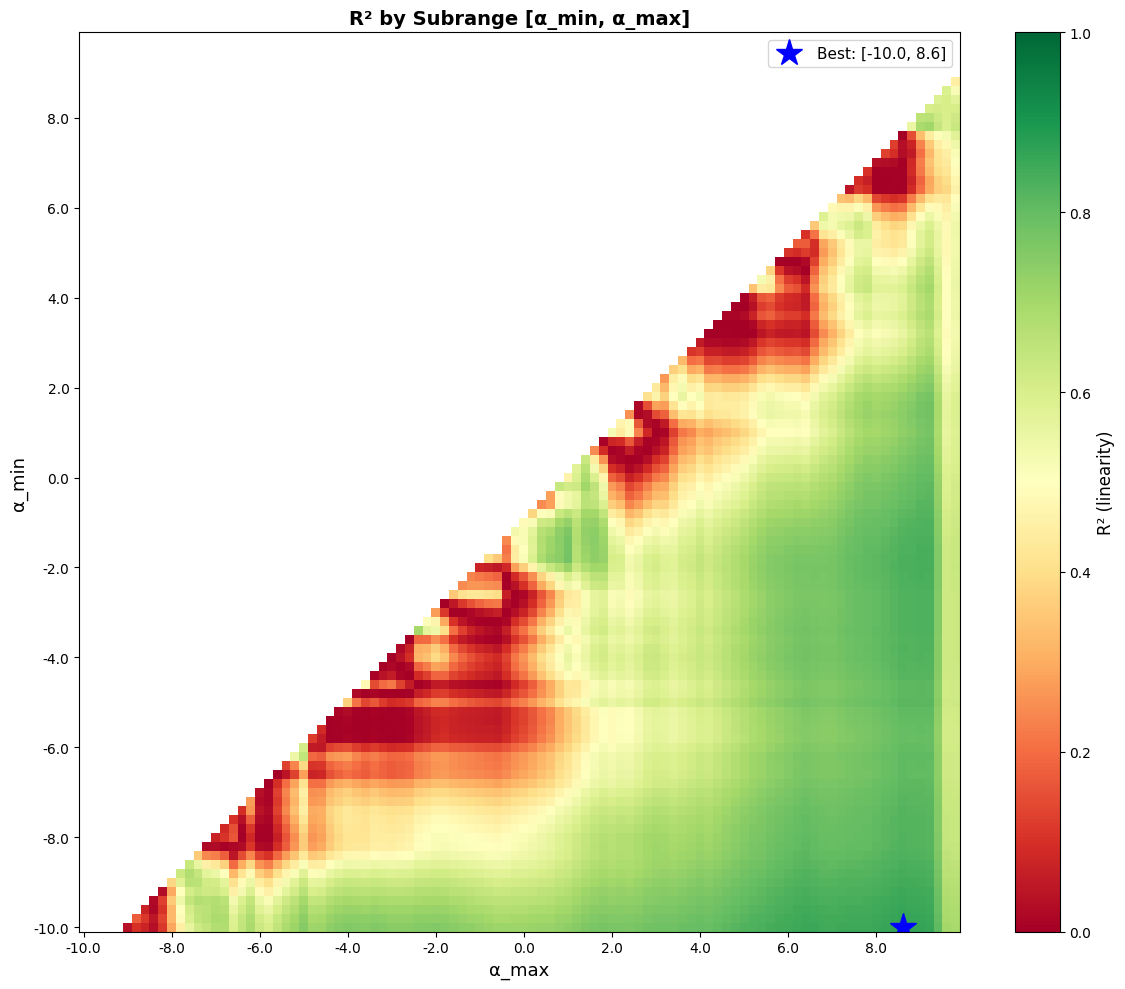

In [11]:
# Create pivot table for heatmap
# Downsample for visualization (every 10th α value)
downsample = 10
alphas_downsampled = alphas[::downsample]

# Build matrix
n_down = len(alphas_downsampled)
r_squared_matrix = np.full((n_down, n_down), np.nan)

for i in range(n_down):
    for j in range(i, n_down):
        alpha_min = alphas_downsampled[i]
        alpha_max = alphas_downsampled[j]
        
        # Find in results
        match = results_df[
            (results_df['alpha_min'] == alpha_min) & 
            (results_df['alpha_max'] == alpha_max)
        ]
        
        if len(match) > 0:
            r_squared_matrix[i, j] = match['r_squared'].values[0]

# Plot
fig, ax = plt.subplots(figsize=(12, 10))

im = ax.imshow(r_squared_matrix, cmap='RdYlGn', vmin=0.0, vmax=1.0, origin='lower', aspect='auto')

# Set ticks
tick_indices = np.arange(0, n_down, max(1, n_down // 10))
ax.set_xticks(tick_indices)
ax.set_yticks(tick_indices)
ax.set_xticklabels([f'{alphas_downsampled[i]:.1f}' for i in tick_indices])
ax.set_yticklabels([f'{alphas_downsampled[i]:.1f}' for i in tick_indices])

ax.set_xlabel('α_max', fontsize=13)
ax.set_ylabel('α_min', fontsize=13)
ax.set_title('R² by Subrange [α_min, α_max]', fontsize=14, fontweight='bold')

# Colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('R² (linearity)', fontsize=12)

# Mark best range
best_i = np.argmin(np.abs(alphas_downsampled - best['alpha_min']))
best_j = np.argmin(np.abs(alphas_downsampled - best['alpha_max']))
ax.plot(best_j, best_i, 'b*', markersize=20, label=f"Best: [{best['alpha_min']:.1f}, {best['alpha_max']:.1f}]")
ax.legend(fontsize=11)

plt.tight_layout()
plt.show()

## Visualization 2: Full Range vs Optimal Range

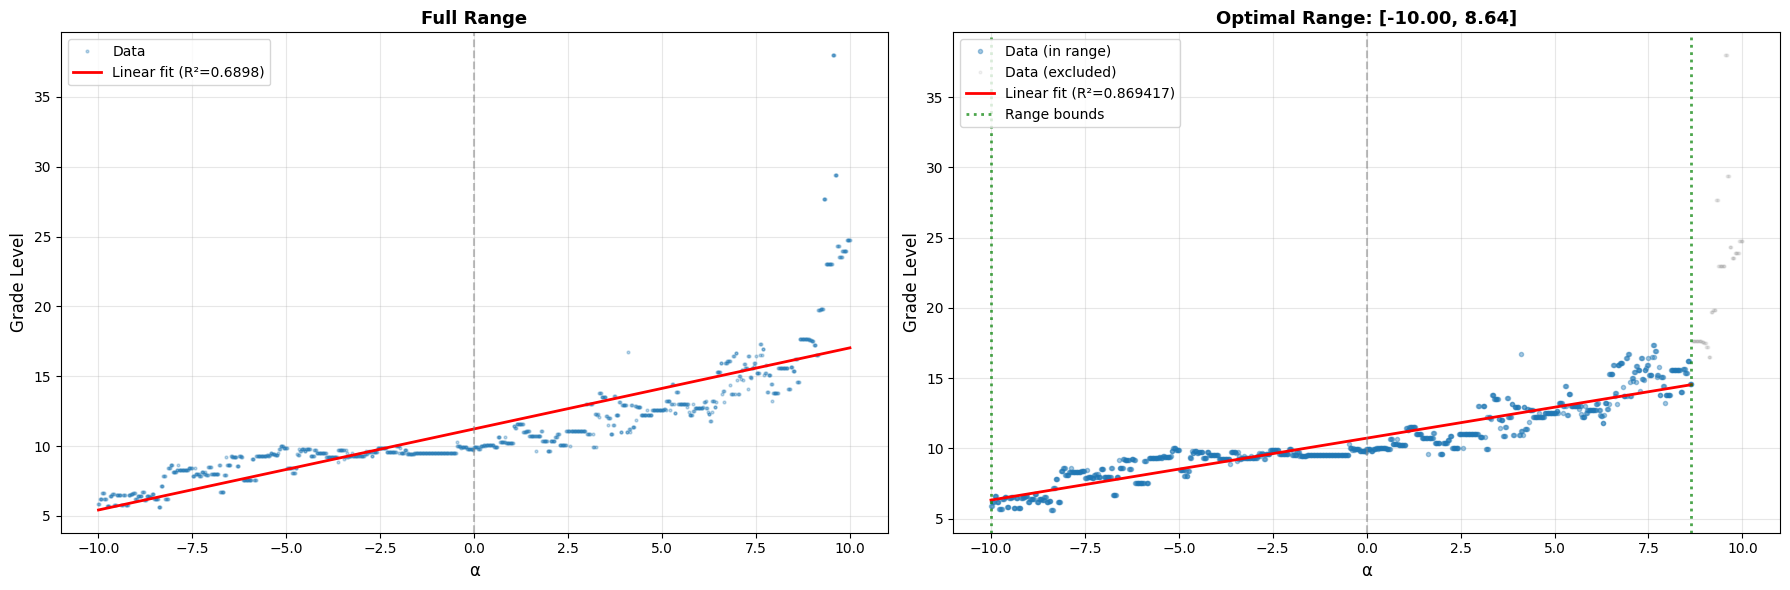

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

# Plot 1: Full range
ax1.plot(df['alpha'], df['grade_level'], 'o', markersize=2, alpha=0.3, label='Data')
fit_x = np.array([df['alpha'].min(), df['alpha'].max()])
fit_y = intercept_full + slope_full * fit_x
ax1.plot(fit_x, fit_y, 'r-', linewidth=2, label=f'Linear fit (R²={r_squared_full:.4f})')
ax1.axvline(0, color='gray', linestyle='--', alpha=0.5)
ax1.set_xlabel('α', fontsize=12)
ax1.set_ylabel('Grade Level', fontsize=12)
ax1.set_title('Full Range', fontsize=13, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Plot 2: Optimal range
mask_best = (df['alpha'] >= best['alpha_min']) & (df['alpha'] <= best['alpha_max'])
subset_best = df[mask_best]

ax2.plot(subset_best['alpha'], subset_best['grade_level'], 'o', markersize=3, alpha=0.4, label='Data (in range)')
ax2.plot(df[~mask_best]['alpha'], df[~mask_best]['grade_level'], 'o', markersize=2, alpha=0.1, color='gray', label='Data (excluded)')
fit_x_best = np.array([best['alpha_min'], best['alpha_max']])
fit_y_best = best['intercept'] + best['slope'] * fit_x_best
ax2.plot(fit_x_best, fit_y_best, 'r-', linewidth=2, label=f'Linear fit (R²={best["r_squared"]:.6f})')
ax2.axvline(0, color='gray', linestyle='--', alpha=0.5)
ax2.axvline(best['alpha_min'], color='green', linestyle=':', alpha=0.7, linewidth=2, label='Range bounds')
ax2.axvline(best['alpha_max'], color='green', linestyle=':', alpha=0.7, linewidth=2)
ax2.set_xlabel('α', fontsize=12)
ax2.set_ylabel('Grade Level', fontsize=12)
ax2.set_title(f'Optimal Range: [{best["alpha_min"]:.2f}, {best["alpha_max"]:.2f}]', fontsize=13, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Visualization 3: Residual Analysis

/var/folders/k5/44vd1ct56xj4y9h7x213kvjr0000gn/T/ipykernel_29015/680731430.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_best['predicted_best'] = best['intercept'] + best['slope'] * subset_best['alpha']
/var/folders/k5/44vd1ct56xj4y9h7x213kvjr0000gn/T/ipykernel_29015/680731430.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_best['residual_best'] = subset_best['grade_level'] - subset_best['predicted_best']


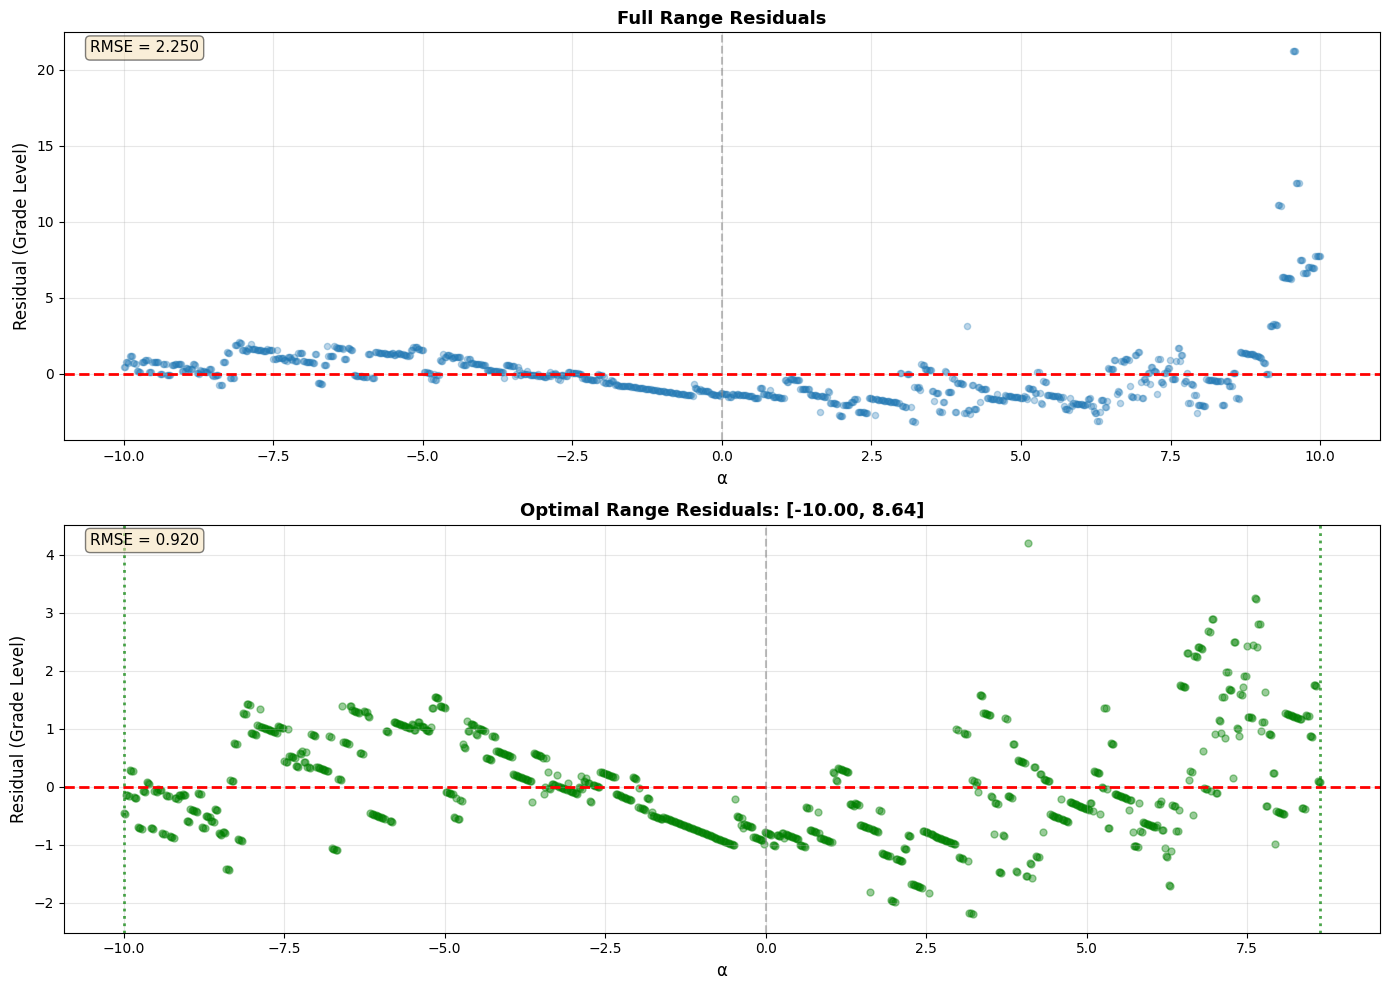


Residual statistics:
  Full range RMSE: 2.250
  Optimal range RMSE: 0.920
  Improvement: 59.1%


In [8]:
# Compute residuals for both fits
df['predicted_full'] = intercept_full + slope_full * df['alpha']
df['residual_full'] = df['grade_level'] - df['predicted_full']

subset_best['predicted_best'] = best['intercept'] + best['slope'] * subset_best['alpha']
subset_best['residual_best'] = subset_best['grade_level'] - subset_best['predicted_best']

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# Full range residuals
ax1.scatter(df['alpha'], df['residual_full'], alpha=0.3, s=20)
ax1.axhline(0, color='red', linestyle='--', linewidth=2)
ax1.axvline(0, color='gray', linestyle='--', alpha=0.5)
ax1.set_xlabel('α', fontsize=12)
ax1.set_ylabel('Residual (Grade Level)', fontsize=12)
ax1.set_title('Full Range Residuals', fontsize=13, fontweight='bold')
ax1.grid(True, alpha=0.3)

# Add stats
rmse_full = np.sqrt(np.mean(df['residual_full']**2))
ax1.text(0.02, 0.98, f'RMSE = {rmse_full:.3f}', transform=ax1.transAxes, 
         fontsize=11, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Optimal range residuals
ax2.scatter(subset_best['alpha'], subset_best['residual_best'], alpha=0.4, s=25, color='green')
ax2.axhline(0, color='red', linestyle='--', linewidth=2)
ax2.axvline(0, color='gray', linestyle='--', alpha=0.5)
ax2.axvline(best['alpha_min'], color='green', linestyle=':', alpha=0.7, linewidth=2)
ax2.axvline(best['alpha_max'], color='green', linestyle=':', alpha=0.7, linewidth=2)
ax2.set_xlabel('α', fontsize=12)
ax2.set_ylabel('Residual (Grade Level)', fontsize=12)
ax2.set_title(f'Optimal Range Residuals: [{best["alpha_min"]:.2f}, {best["alpha_max"]:.2f}]', fontsize=13, fontweight='bold')
ax2.grid(True, alpha=0.3)

# Add stats
rmse_best = np.sqrt(np.mean(subset_best['residual_best']**2))
ax2.text(0.02, 0.98, f'RMSE = {rmse_best:.3f}', transform=ax2.transAxes, 
         fontsize=11, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

print(f"\nResidual statistics:")
print(f"  Full range RMSE: {rmse_full:.3f}")
print(f"  Optimal range RMSE: {rmse_best:.3f}")
print(f"  Improvement: {(rmse_full - rmse_best) / rmse_full * 100:.1f}%")

## Analysis: Top 10 Most Linear Ranges

In [9]:
# Show top 10 ranges by R²
top_10 = results_df.nlargest(10, 'r_squared')[[
    'alpha_min', 'alpha_max', 'range_width', 'n_samples', 'slope', 'r_squared'
]]

print("\nTop 10 most linear subranges:")
print(top_10.to_string(index=False))

# Show ranges with different widths
print("\n=== Best ranges by width ===")
for width_threshold in [5, 10, 15, 20]:
    wide_enough = results_df[results_df['range_width'] >= width_threshold]
    if len(wide_enough) > 0:
        best_wide = wide_enough.nlargest(1, 'r_squared').iloc[0]
        print(f"\nWidth ≥ {width_threshold}:")
        print(f"  Range: [{best_wide['alpha_min']:.2f}, {best_wide['alpha_max']:.2f}]")
        print(f"  R² = {best_wide['r_squared']:.6f}")
        print(f"  Slope = {best_wide['slope']:.3f}")


Top 10 most linear subranges:
 alpha_min  alpha_max  range_width  n_samples    slope  r_squared
 -10.00000   8.638639    18.638639        932 0.440525   0.869417
 -10.00000   8.618619    18.618619        931 0.440497   0.869037
  -9.97998   8.638639    18.618619        931 0.440368   0.869000
 -10.00000   8.658659    18.658659        933 0.441599   0.868943
 -10.00000   8.598599    18.598599        930 0.440465   0.868655
  -9.97998   8.618619    18.598599        930 0.440339   0.868618
  -9.95996   8.638639    18.598599        930 0.440206   0.868580
  -9.97998   8.658659    18.638639        932 0.441445   0.868525
 -10.00000   8.678679    18.678679        934 0.442664   0.868498
 -10.00000   8.578579    18.578579        929 0.440431   0.868270

=== Best ranges by width ===

Width ≥ 5:
  Range: [-10.00, 8.64]
  R² = 0.869417
  Slope = 0.441

Width ≥ 10:
  Range: [-10.00, 8.64]
  R² = 0.869417
  Slope = 0.441

Width ≥ 15:
  Range: [-10.00, 8.64]
  R² = 0.869417
  Slope = 0.441

Width 